In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from google.colab import files
uploaded = files.upload()

Saving fertilizer_recommendation_dataset.csv to fertilizer_recommendation_dataset (1).csv


In [32]:
import pandas as pd
df_fertilizer = pd.read_csv('fertilizer_recommendation_dataset.csv')
print(df_fertilizer.head())

   Temperature  Moisture    Rainfall        PH   Nitrogen  Phosphorous  \
0    50.179845  0.725893  205.600816  6.227358  66.701872    76.963560   
1    21.633318  0.721958  306.081601  7.173131  71.583316   163.057636   
2    23.060964  0.685751  259.336414  7.380793  75.709830    62.091508   
3    26.241975  0.755095  212.703513  6.883367  78.033687   151.012521   
4    21.490157  0.730672  268.786767  7.578760  71.765123    66.257371   

    Potassium    Carbon        Soil  Crop                  Fertilizer  \
0   96.429065  0.496300  Loamy Soil  rice                     Compost   
1  148.128347  1.234242  Loamy Soil  rice     Balanced NPK Fertilizer   
2   80.308971  1.795650  Peaty Soil  rice  Water Retaining Fertilizer   
3  153.005712  1.517556  Loamy Soil  rice     Balanced NPK Fertilizer   
4   97.000886  1.782985  Peaty Soil  rice          Organic Fertilizer   

                                              Remark  
0  Enhances organic matter and improves soil stru...  
1  Pro

In [33]:
f = df_fertilizer.drop('Fertilizer', axis=1)

t = df_fertilizer['Fertilizer']

In [34]:
labels = df_fertilizer['Fertilizer'].unique()
print(labels)

['Compost' 'Balanced NPK Fertilizer' 'Water Retaining Fertilizer'
 'Organic Fertilizer' 'Gypsum' 'Lime' 'DAP' 'Urea' 'Muriate of Potash'
 'General Purpose Fertilizer']


In [35]:
categorical_cols = [col for col in f.columns if f[col].dtype == 'object']
print(categorical_cols)

['Soil', 'Crop', 'Remark']


In [36]:
for col in categorical_cols:
    unique_vals = f[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    f[col] = f[col].map(mapping)

In [37]:
unique_labels = sorted(df_fertilizer['Fertilizer'].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
t = df_fertilizer['Fertilizer'].map(label_mapping).to_numpy()

In [38]:
f = f.to_numpy()

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class DecisionTree:
    def __init__(self, f_i=None, delta=None, l_l=None, l_r=None, *, leaf_val=None, min_l=2, max_d=100, num_f=None, random_state=None):
        self.f_i = f_i
        self.delta = delta
        self.l_l = l_l
        self.l_r = l_r
        self.leaf_val = leaf_val
        self.min_l = min_l
        self.max_d = max_d
        self.num_f = num_f
        self.random_state = random_state
        if self.random_state is not None:
            np.random.seed(self.random_state)

    def leaf(self):
        return self.leaf_val is not None

    def train1(self, X1, y1):
        self.num_f = X1.shape[1] if self.num_f is None else min(X1.shape[1], self.num_f)
        self.root = self.subtree(X1, y1)

    def subtree(self, X1, y1, d=0):
        if self.stop_split(X1, y1, d):
            return DecisionTree(leaf_val=self.mfl(y1))
        top_f, top_delta = self.find_best_split(X1, y1)
        if top_f is None or top_delta is None:
            return DecisionTree(leaf_val=self.mfl(y1))
        return self.split_recurse(X1, y1, d)


    def stop_split(self, X1, y1, d):
        return d >= self.max_d or len(np.unique(y1)) == 1 or X1.shape[0] < self.min_l

    def split_recurse(self, X1, y1, d):
        top_f, top_delta = self.find_best_split(X1, y1)

        if top_f is None or top_delta is None:
            return DecisionTree(leaf_val=self.mfl(y1))

        l_i, r_i = self.data(X1[:, top_f], top_delta)
        return DecisionTree(
            f_i=top_f,
            delta=top_delta,
            l_l=self.subtree(X1[l_i, :], y1[l_i], d + 1),
            l_r=self.subtree(X1[r_i, :], y1[r_i], d + 1)
        )

    def find_best_split(self, X1, y1):
        top_gain, top_f, top_delta = -1, None, None
        m = int(np.sqrt(X1.shape[1]))
        for f in np.random.choice(X1.shape[1], m, replace=False):
            unique_vals = np.unique(X1[:, f])
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2  # Midpoints as thresholds
            for delta in thresholds:
                gain = self.ig(y1, X1[:, f], delta)
                if gain > top_gain:
                    top_f, top_delta, top_gain = f, delta, gain
        return top_f, top_delta

    def ig(self, y1, f_val, delta):
        ancestor_e = self.e(y1)
        l_i, r_i = self.data(f_val, delta)
        if not l_i.size or not r_i.size:
            return 0
        return ancestor_e - self.weighted_e(y1, l_i, r_i)

    def weighted_e(self, y1, l_i, r_i):
        total = len(y1)
        return (len(l_i) / total) * self.e(y1[l_i]) + (len(r_i) / total) * self.e(y1[r_i])

    def e(self, y1):
        if not y1.size:
            return 0
        p = np.bincount(y1.astype(int)) / len(y1)
        return -np.sum(p[p > 0] * np.log2(p[p > 0]))

    def data(self, f_val, delta):
        return np.where(f_val <= delta)[0], np.where(f_val > delta)[0]

    def mfl(self, y1):
        return Counter(y1).most_common(1)[0][0]

    def pediting(self, X1):
        return np.array([self.tt(sample, self.root) for sample in X1])

    def tt(self, n, r):
        if r.leaf():
            return r.leaf_val
        return self.tt(n, r.l_l if n[r.f_i] <= r.delta else r.l_r)

In [40]:
def encode_categorical(df):
    categories = {}
    for col in df.columns:
        unique_vals = sorted(df[col].unique())
        categories[col] = {val: idx for idx, val in enumerate(unique_vals)}
        df[col] = df[col].map(categories[col])
    return df

def compute_metrics(t_true, t_pred):
    labels = np.unique(t_true)
    precisions, recalls, f1_scores = [], [], []

    for label in labels:
        TP = np.sum((t_true == label) & (t_pred == label))
        FP = np.sum((t_true != label) & (t_pred == label))
        FN = np.sum((t_true == label) & (t_pred != label))

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    acc = np.sum(t_true == t_pred) / len(t_true)
    precision_macro = np.mean(precisions)
    recall_macro = np.mean(recalls)
    f1_macro = np.mean(f1_scores)

    return acc, precision_macro, recall_macro, f1_macro

def mskf(f, t, k=10, seed=42):
    np.random.seed(seed)
    unique_classes = np.unique(t)
    class_indices = {label: np.where(t == label)[0] for label in unique_classes}
    for label in unique_classes:
        np.random.shuffle(class_indices[label])
    folds = [[] for _ in range(k)]
    for label in unique_classes:
        split_indices = np.array_split(class_indices[label], k)
        for fold_idx, fold in enumerate(split_indices):
            folds[fold_idx].extend(fold)
    return [np.array(fold) for fold in folds]


def stratified_kf_decision_tree(f, t, max_depth_list, k=10):
    f_folds = mskf(f, t, k=k)
    rst = {depth: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for depth in max_depth_list}

    for i in range(k):
        test_idx = f_folds[i]
        train_idx = np.hstack([f_folds[j] for j in range(k) if j != i])
        f_train, f_test = f[train_idx], f[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        for depth in max_depth_list:
            dt = DecisionTree(min_l=2, max_d=depth, random_state=42)
            dt.train1(f_train, t_train)
            t_pred = dt.pediting(f_test)

            acc, prec, rec, f1 = compute_metrics(t_test, t_pred)

            rst[depth]['accuracy'].append(acc)
            rst[depth]['precision'].append(prec)
            rst[depth]['recall'].append(rec)
            rst[depth]['f1'].append(f1)

    return {depth: {metric: np.mean(rst[depth][metric]) for metric in rst[depth]} for depth in rst}


def plot_results(rst, title="Decision Tree Performance"):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.plot(list(rst.keys()), [rst[d][metric] for d in rst.keys()], marker='o', linestyle='-')
        plt.xlabel("Max Depth")
        plt.ylabel(metric.capitalize())
        plt.title(f"{title} - {metric.capitalize()}")
        plt.grid(True)
        plt.show()

In [41]:
def print_results(results):
    print(f"{'MaxDepth':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    for depth, metrics in results.items():
        print(f"{depth:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")

MaxDepth   Accuracy   Precision  Recall     F1        
2          0.6629     0.2196     0.3000     0.2504    
4          0.8161     0.4664     0.5052     0.4713    
6          0.9507     0.8448     0.8072     0.8168    
8          0.9678     0.8616     0.8508     0.8471    
10         0.9803     0.9387     0.9123     0.9158    
12         0.9861     0.9587     0.9455     0.9493    


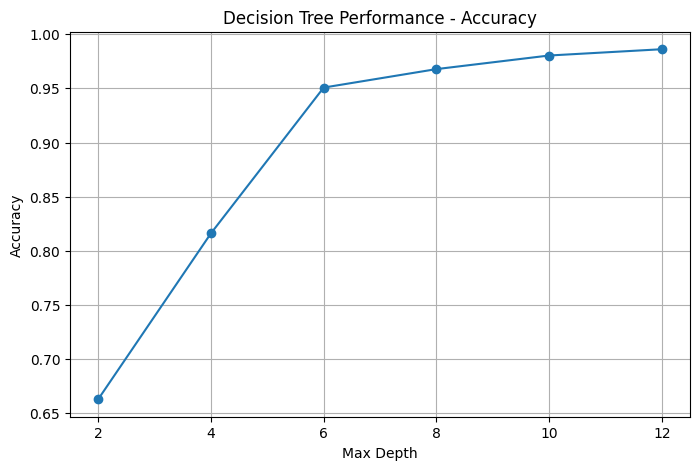

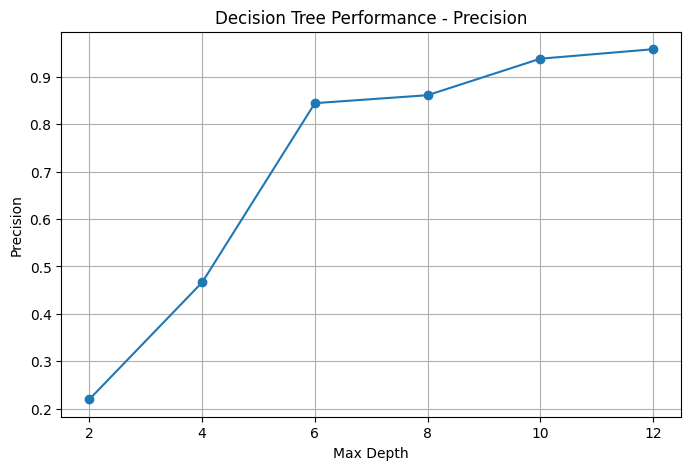

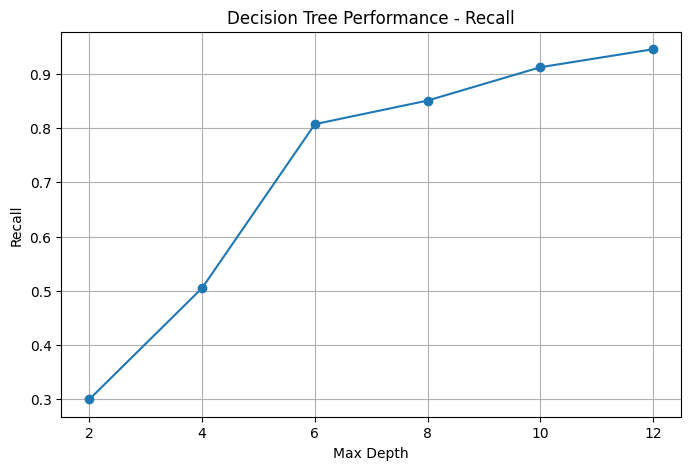

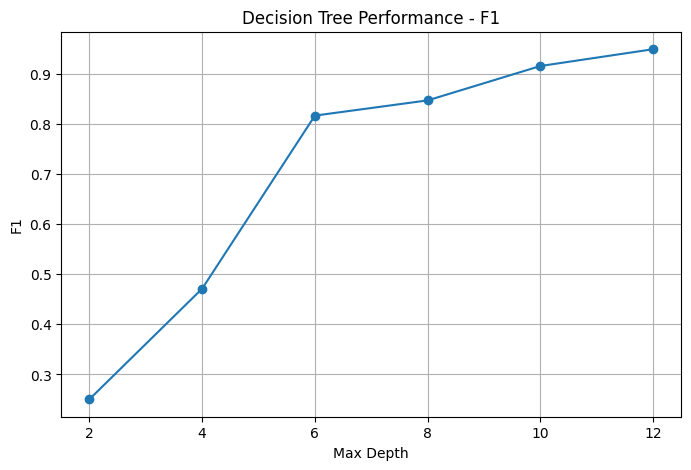

In [42]:
depths = [2, 4, 6, 8, 10, 12]
results = stratified_kf_decision_tree(f, t, max_depth_list=depths, k=10)
print_results(results)
plot_results(results, title="Decision Tree Performance")

In [43]:
def evaluate_best_depth(f, t, best_depth, k=10):
    f_folds = mskf(f, t, k=k)
    train_accuracies = []
    test_accuracies = []

    for i in range(k):
        test_idx = f_folds[i]
        train_idx = np.hstack([f_folds[j] for j in range(k) if j != i])
        f_train, f_test = f[train_idx], f[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        dt = DecisionTree(min_l=2, max_d=best_depth, random_state=42)
        dt.train1(f_train, t_train)
        t_pred_train = dt.pediting(f_train)
        train_acc = np.sum(t_train == t_pred_train) / len(t_train)
        train_accuracies.append(train_acc)
        t_pred_test = dt.pediting(f_test)
        test_acc = np.sum(t_test == t_pred_test) / len(t_test)
        test_accuracies.append(test_acc)

    return np.array(train_accuracies), np.array(test_accuracies)


In [44]:
def plot(accuracies, title):
    accuracy_mean = np.mean(accuracies)
    SD_accuracy = np.std(accuracies)

    plt.figure(figsize=(10, 5))
    plt.hist(accuracies, bins=10, edgecolor='black', alpha=0.7)
    plt.axvline(accuracy_mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {accuracy_mean:.3f}")
    plt.axvline(accuracy_mean - SD_accuracy, color='blue', linestyle='dashed', linewidth=2, label=f"1 Std Dev: {accuracy_mean - SD_accuracy:.3f}")
    plt.axvline(accuracy_mean + SD_accuracy, color='blue', linestyle='dashed', linewidth=2)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Mean Accuracy: {accuracy_mean:.3f}")
    print(f"Standard Deviation of Accuracy: {SD_accuracy:.3f}")

Best max depth is: 12


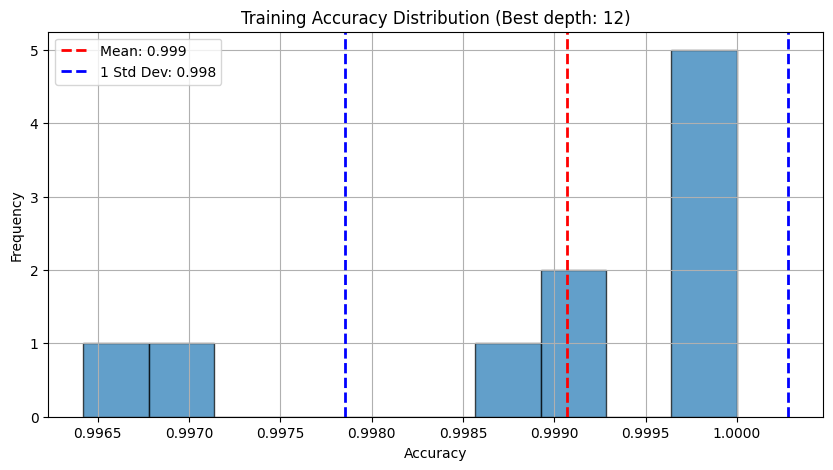

Mean Accuracy: 0.999
Standard Deviation of Accuracy: 0.001


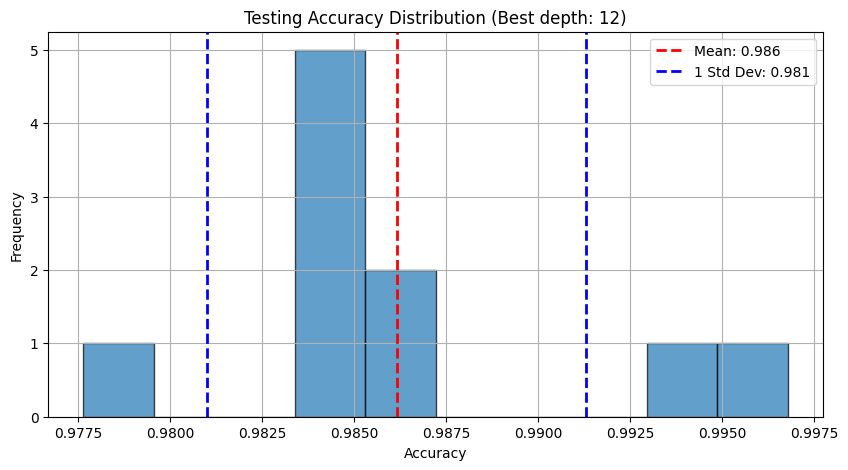

Mean Accuracy: 0.986
Standard Deviation of Accuracy: 0.005


In [45]:
best_depth = max(results, key=lambda d: results[d]['accuracy'])
print(f"Best max depth is: {best_depth}")
train_acc, test_acc = evaluate_best_depth(f, t, best_depth, k=10)

plot(train_acc, f"Training Accuracy Distribution (Best depth: {best_depth})")
plot(test_acc, f"Testing Accuracy Distribution (Best depth: {best_depth})")

In [46]:
def evaluate_best_depth(f, t, best_depth, k=10):
    f_folds = mskf(f, t, k=k)
    train_f1s = []
    test_f1s = []

    for i in range(k):
        test_idx = f_folds[i]
        train_idx = np.hstack([f_folds[j] for j in range(k) if j != i])
        f_train, f_test = f[train_idx], f[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        dt = DecisionTree(min_l=2, max_d=best_depth, random_state=42)
        dt.train1(f_train, t_train)
        t_pred_train = dt.pediting(f_train)
        _, _, _, train_f1 = compute_metrics(t_train, t_pred_train)
        train_f1s.append(train_f1)
        t_pred_test = dt.pediting(f_test)
        _, _, _, test_f1 = compute_metrics(t_test, t_pred_test)
        test_f1s.append(test_f1)

    return np.array(train_f1s), np.array(test_f1s)

In [47]:
train_f1, test_f1 = evaluate_best_depth(f, t, best_depth, k=10)

In [48]:
def plot_F1(F1, title):
    F1_mean = np.mean(F1)
    SD_F1 = np.std(F1)

    plt.figure(figsize=(10, 5))
    plt.hist(F1, bins=10, edgecolor='black', alpha=0.7)
    plt.axvline(F1_mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {F1_mean:.3f}")
    plt.axvline(F1_mean - SD_F1, color='blue', linestyle='dashed', linewidth=2, label=f"1 Std Dev: {F1_mean - SD_F1:.3f}")
    plt.axvline(F1_mean + SD_F1, color='blue', linestyle='dashed', linewidth=2)
    plt.xlabel("F1")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Mean F1 Score: {F1_mean:.3f}")
    print(f"Standard Deviation of F1 Score: {SD_F1:.3f}")

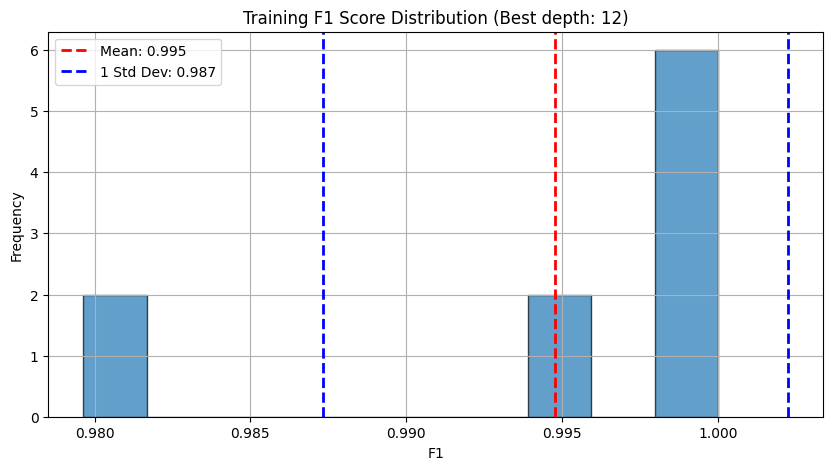

Mean F1 Score: 0.995
Standard Deviation of F1 Score: 0.007


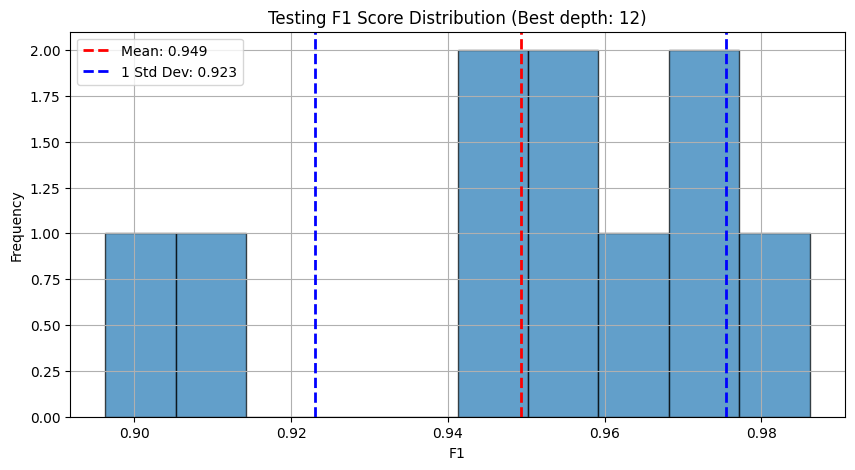

Mean F1 Score: 0.949
Standard Deviation of F1 Score: 0.026


In [49]:
plot_F1(train_f1, f"Training F1 Score Distribution (Best depth: {best_depth})")
plot_F1(test_f1, f"Testing F1 Score Distribution (Best depth: {best_depth})")